# Hawkes Processes for cyber attacks modelling


Authors : Vincent Herfeld, Maxime Megel, Simon Queric 

Date : 12/06/23

References : - Multivariate Hawkes process for cyber insurance

In [1]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
from scipy.stats import expon, kstest
import numpy as np
import matplotlib.pylab as plt

## 1. Loading the data

We had some troubles when several attacks occured a same day with jumps greater than 1. Hence we chose to evenly spaced these attacks. To be more precise we should have the precise hour of these attacks.

In [2]:
df = pd.read_csv("PRC.csv",sep=';')
t = df[df["Type of breach"]=="HACK"]
t = t["Date Made Public"]
t = t.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut = min(t)
t = t - debut
t = t.apply(lambda x:x.days).sort_values()
debut, fin = int(min(t)), int(max(t))
t = t.to_frame()

In [3]:
t["Date Made Public"] = t.apply(lambda x : float(x), axis=1)

In [4]:
# We space evenly the attacks that occured the same day

for k in range(debut, fin+1) :
    x = t[t["Date Made Public"]==k]
    if len(x)>1 :
        l = len(x)
        ind = x.index
        for i in range(l) :  
            t.loc[ind[i]]["Date Made Public"] += i/l

In [5]:
times = np.asarray(t["Date Made Public"])

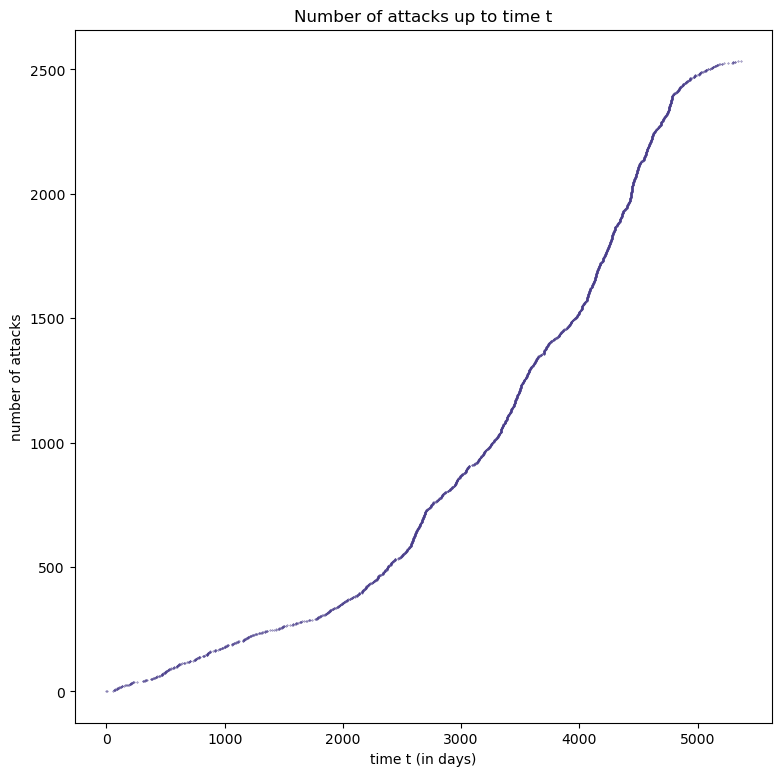

In [6]:
n = len(times)

fig = plt.figure(figsize=(9, 9))
plt.scatter(times,1+np.arange(n), s = 0.1, c = 'darkslateblue')
plt.title("Number of attacks up to time t")
plt.xlabel("time t (in days)")
plt.ylabel("number of attacks")
plt.show()

## 2. Log-likelihood estimation of the parameters 

### 2.1 Estimation of the parameters of the model

We suppose that time of attacks follows a Hawkes process $N$ which is a point process with intensity :

$$ \dot{y}(N, t) = \alpha + \beta \int_0^{t^-}{e^{-\gamma(t-s)}dN(s)}$$

The log-likelihood associated to the model is given by : 

$$ \log{L(N, t)} = \sum_{T_n\leqslant t}log{\left( \alpha + \beta\sum_{j=1}^{n-1}{e^{-\gamma(T_n - T_j)}}\right) + (1-\alpha)t - \frac{\beta}{\gamma}\sum_{T_n\leqslant t}{\left(1 - e^{-\gamma(t-T_n)}\right)}}$$

We will choose $t = T_m$ with $m$ the number of observations.


In order to find the parameters of the model $\alpha, \beta$ and $\gamma$ we have to solve the following optimization problem :

$$\text{argmax}_{\alpha, \beta, \gamma}-\log{L(N, t)}  $$

under 

$$\alpha \geqslant 0, \beta \geqslant 0, \gamma \geqslant 0, \frac{\beta}{\gamma} < 1$$

We use the function `optimize` from the library `scipy.optimize` to estimate the parameters of the model.

In [7]:
def negloglikelihood(param, t=times[-1], times=times) :
    L = 0
    alpha, beta, gamma = param[0], param[1], param[2]
    L+= (1 - alpha)*t
    L+= - beta/gamma * np.sum(1 - np.exp(-gamma*(t - times)))
    s = np.array([np.sum(np.exp(-gamma*(times[n] - times[:n]))) for n in range(len(times))])
    L+= np.sum(np.log(alpha + beta*s))
    
    # we then return -L instead of L because we want to maximize L which is equivalent to minimizing -L
    return -L

In [8]:
# We want to find the maximum for the loglikelihood with the following constraints : 
# alpha >= 0
# beta >= 0
# gamma >= 0
# beta/gamma < 1

from scipy.optimize import NonlinearConstraint
con1 = NonlinearConstraint(lambda x : x[0], 0, np.inf)
con2 = NonlinearConstraint(lambda x : x[1], 0, np.inf)
con3 = NonlinearConstraint(lambda x : x[2], 0, np.inf)
con4 = NonlinearConstraint(lambda x : x[1]/x[2], 0, 1)

We tested two optimization methods, with and without constraints.
Both methods give us the same results.

In [9]:
parameters = minimize(fun=negloglikelihood, x0=np.array([1, 1, 2]), constraints = [con1, con2, con3, con4], tol=1e-5)

C:\Users\mmege\AppData\Local\Temp\ipykernel_7184\354457369.py:7: RuntimeWarning: invalid value encountered in log
  L+= np.sum(np.log(alpha + beta*s))
C:\Users\mmege\AppData\Local\Temp\ipykernel_7184\354457369.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  L+= - beta/gamma * np.sum(1 - np.exp(-gamma*(t - times)))
C:\Users\mmege\AppData\Local\Temp\ipykernel_7184\354457369.py:5: RuntimeWarning: invalid value encountered in double_scalars
  L+= - beta/gamma * np.sum(1 - np.exp(-gamma*(t - times)))
C:\Users\mmege\AppData\Local\Temp\ipykernel_7184\1495734821.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  con4 = NonlinearConstraint(lambda x : x[1]/x[2], 0, 1)


In [10]:
#parameters = minimize(fun=negloglikelihood, x0=np.array([1, 1, 2]), method = 'Nelder-Mead')

In [11]:
parameters

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1561.5575524354163
       x: [ 4.415e-02  4.322e-02  4.764e-02]
     nit: 46
     jac: [-1.645e-02 -1.680e-01  1.552e-01]
    nfev: 220
    njev: 44

In [12]:
alpha, beta, gamma = parameters.x

In [13]:
alpha, beta, gamma

(0.044153066242625626, 0.043217766789187005, 0.04764225922209017)

We can now compute $y(N, T_q(N))_{q\geqslant 1}$  :

$$ y(t) = \alpha t + \frac{\beta}{\gamma}\sum_{T_n<t}{\left( 1 - e^{-\gamma(t-T_n)}\right)}$$ 

In [14]:
def y(time, q) :
    """return y(T_q)"""
    return alpha * times[q] + beta/gamma * np.sum(1 - np.exp(-gamma * (times[q] - times[:q])))

In [15]:
T = np.array([y(times, q) for q in range(n)])

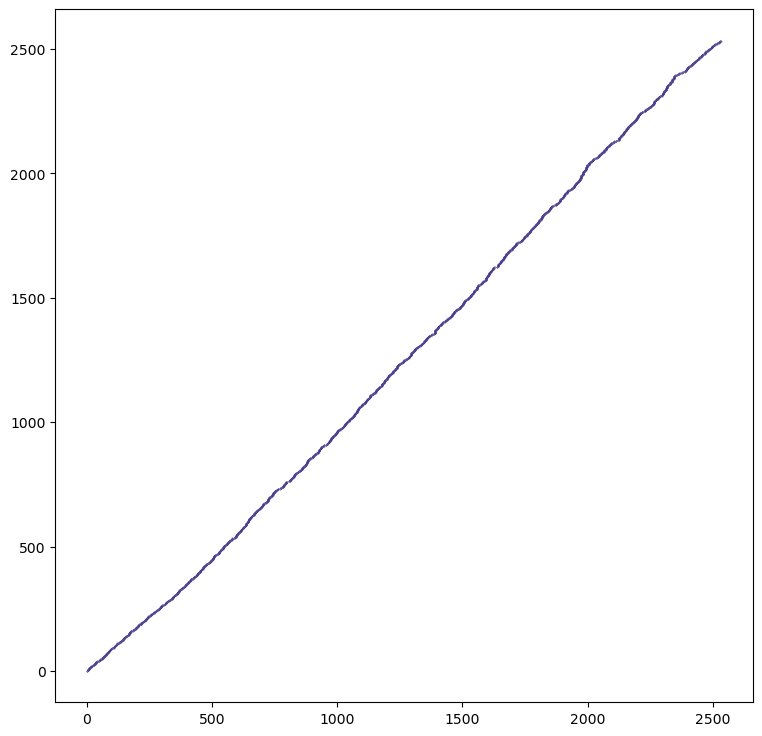

In [16]:
fig=plt.figure(figsize=(9, 9))
plt.scatter(T, 1+np.arange(len(T)), c = 'darkslateblue', s=0.1)
plt.show()

As expected, by changing the time scale, we obtain a point process $(M(t), t\geqslant 0)$ which seems to be a Poisson process of intensity $1$. We can see above that $M(t) \sim t$. Let's take a closer look by comparing with a "real" Poisson process of intensity $1$ :

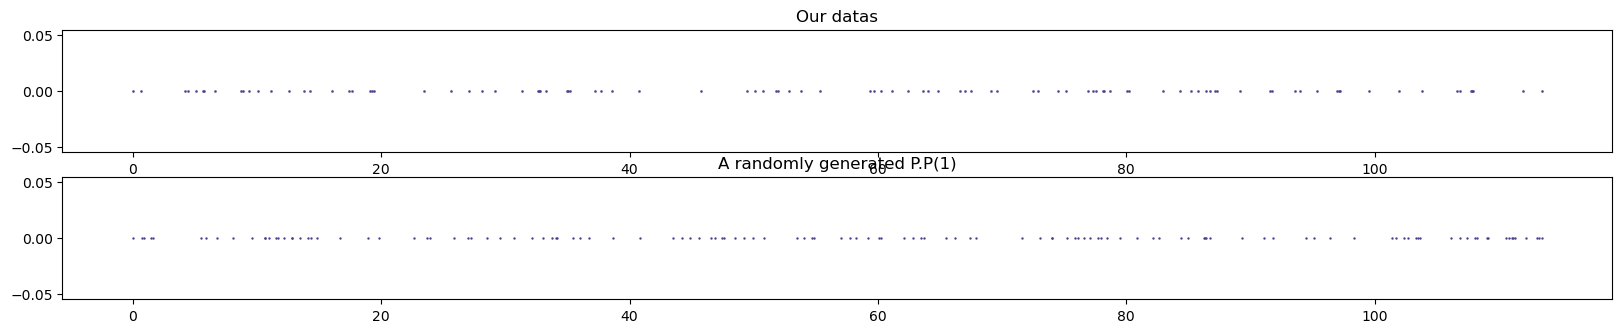

In [17]:
k = 100

t_max = T[k-1]
res = []
T_current = 0

#First we generate N_a
while T_current < t_max:
    res.append(T_current)
    T_current += np.random.exponential(1)
res.append(t_max)

plt.figure(figsize = (20, 3.5))
plt.subplot(211)
plt.scatter(T[:k], np.zeros(k), s = 1, c = 'darkslateblue', alpha = 0.8)
plt.title('Our datas')

plt.subplot(212)
plt.scatter(res, np.zeros(len(res)), s = 0.5, c = 'darkslateblue')
plt.title('A randomly generated P.P(1)')
plt.show()

## 3. Test hypothesis

We now want to test if $y(N, T_q(N))_{q\geqslant 1}$ is a Poisson process with intensity equals to $1$.

We define $\xi_q = y(N, T_q(N)) - y(N, T_{q-1}(N))$, and we want to test if $(\xi_i)_i$ is a i.i.d sequence with $\xi_1\sim\mathcal{E}(1)$.  
The identical distribution of the $\xi_q$'s can't be tested as we only have one sample of each variable, we will therefore **assume it from the start.**

Let's first have a look to an histogram of the distribution of the $\xi_q$'s and compare it to the theoritical pdf of an exponential variable of parameter 1.

<Figure size 900x600 with 0 Axes>

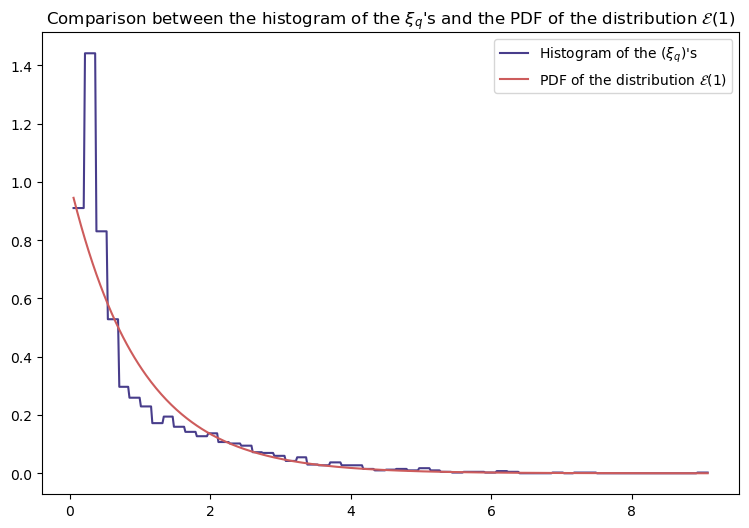

In [24]:
plt.figure(figsize = (9, 6))

diff = np.diff(T) #An array containing all the xi_q's
h, bins = np.histogram(diff, bins = 'auto', density = True)
a = bins[0] #lower bound
b = bins[-1] #upper bound

#A function to compute a "continuous" version of the histogram, given a time range
def H(ts, h = h, b = bins[1:]):
    q = 0
    n = len(ts)
    res = np.zeros(n)
    for k in range(n):
        if ts[k] > b[q]:
            q+=1
        res[k] = h[q]
    return res

ts = np.linspace(a, b, 500) #A time range for the plot
Hts = H(ts)
ets = np.exp(-ts) #the theoritical pdf

plt.figure(figsize = (9,6))
plt.plot(ts, Hts, c = 'darkslateblue', label = r"Histogram of the $(\xi_q)$'s")
plt.plot(ts, ets, c = 'indianred', label = r'PDF of the distribution $\mathcal{E}(1)$')

plt.title(r"Comparison between the histogram of the $\xi_q$'s and the PDF of the distribution $\mathcal{E}(1)$")
plt.legend()
plt.show()

We can already see that visually, we have a quite convincing result. The tail fits very well, even if the slope seems steeper at the beggining of the curve. But we still have to test more precisely the accuracy of our method result more precisely.  
An interesting way to compute the accuracy of our histogram is to compute the MSE between the expected pdf and the histogram :

$\displaystyle MSE = \frac{1}{b-a} \int_a^b\left(H(t) - e^{-t}\right)^2\,dt$

Using that $H(t)$ can be written in the form :

$\displaystyle H(t) = \sum_{k = 1}^mH_k\mathbb{1}_{B_k}(t)$

With $B_k = \left[a + (k-1)s, a + ks\right]$, $s$ being defined as $s = \frac{b-a}{m}$, we can easily compute the MSE analytically. Without going through the details, we get :

$\boxed{\displaystyle MSE = \frac{1}{b-a}\left[\frac{1}{2}\left(e^{-2a} - e^{-2b}\right) + 2(e^{-s} - 1)\sum_{k = 1}^mH_ke^{-t_k} + s\sum_{k = 1}^mH_k^2\right]}$

With $t_k = a + (k-1)s$.

In [19]:
def MSE(h, bins):
    m = len(h)
    a = bins[0]
    b = bins[-1]
    s = bins[1] - bins[0]
    return (1/2 * (np.exp(-2*a) - np.exp(-2*b)) + 2 * (np.exp(-s) - 1) * (h * np.exp( - bins[:-1])).sum() + s * (h**2).sum()) / (b-a)

mse = MSE(h, bins)
print(mse)

0.010681371990705752


A way to get a more interpretable result is to compute the squared root of the MSE, in order to have a result that is of the same unity of the pdf :

In [20]:
print(np.sqrt(mse))

0.10335072322294485


The total error is about 10% of 1 (the value of the integral), which is not excellent yet still not horrible. Therefore we see that our model is indeed an approximation but that gives acceptable result.

### Kolmogorov-Smirnov test

In [22]:
from scipy.stats import kstest
kstest(diff, lambda x : (1 - np.exp(-x))*(x>0))

KstestResult(statistic=0.09792227866363934, pvalue=1.3836094444820081e-21, statistic_location=0.6393749320168354, statistic_sign=1)

We also performed a KS test to see if $\xi_q$ follow an exponential distribution of parameter $1$ but it's not convincing since the pvalue is really small ($1.3\cdot 10^{-21}$). 

### Independancy

We now want to test if the $\xi_q$'s are independant. We can make the reasonable asumption that if there is any dependancy between $\xi_{q_1}$ and $\xi_{q_2}$, this dependancy is only due to the proximity of $q_1$ and $q_2$. That asumption naturally brings us to compute the autocorrelation function of the process $(\xi_q)_q$.

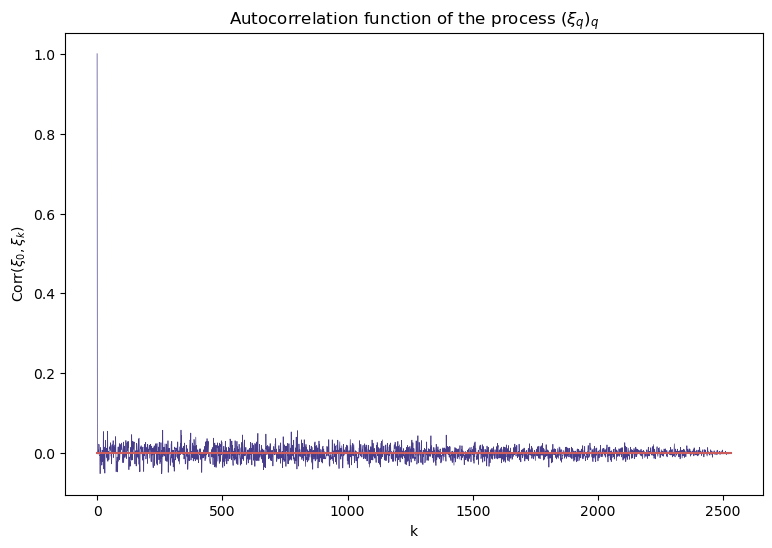

In [21]:
def autocorr(data):
    n = len(data)
    mean = np.mean(data)
    centered_data = data - mean

    autocorr = np.correlate(centered_data, centered_data, mode='full')
    autocorr = autocorr[n-1:]  # Only keep positive values
    autocorr = autocorr / (n * np.var(data))  # Normalization

    return autocorr

auto_corr = autocorr(diff)
plt.figure(figsize = (9,6))
plt.plot(auto_corr, c = 'darkslateblue', lw = 0.5)
plt.plot([0, len(auto_corr)], [0, 0], c = 'indianred')
plt.xlabel('k')
plt.ylabel(r'Corr($\xi_0, \xi_k$)')
plt.title(r'Autocorrelation function of the process $(\xi_q)_q$')
plt.show()

We can see that the correlations are very close to $0$, confirming that the samples are indeed independant.